# Customer Segmentation

## Data 

For the purpose of data collection, the Online Retail dataset available from UCI Machine Learning repository was utilized. This dataset comprises transactional records spanning from December 1st, 2010 to December 9th, 2011, capturing the transactions of a Europe-based online retail platform. Each row within the dataset represents a distinct transaction event. The dataset encompasses essential transaction details such as product names, quantities, prices, and distinctive identification columns. For analytical purposes, a subset of 10000 rows was thoughtfully sampled, thereby being regarded as a representative subset of the entirety of customer transactions.

### RFM

RFM stands for Recency, Frequency, and Monetary Value, and it is a widely used technique in marketing and customer analytics. RFM analysis is a method that categorizes customers based on their past behavior, focusing on three main aspects:

1. Recency (R): This refers to how recently a customer has made a purchase. Customers who have made a purchase more recently are considered more engaged and active.

2. Frequency (F): Frequency indicates how often a customer makes purchases. Customers who make purchases frequently are typically more loyal and valuable to a business.

3. Monetary Value (M): Monetary value represents the amount of money a customer has spent on purchases. High monetary value customers are often considered key contributors to a business's revenue.

By evaluating these three aspects—Recency, Frequency, and Monetary Value—RFM analysis helps classify customers into different segments based on their behavior. This approach allows businesses to tailor their marketing strategies and engagement efforts to each segment's specific characteristics and needs.







## Importing all required Libraries & Loading Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime, timedelta

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

In [100]:
# Loading the data
df = pd.read_csv('online_retail.csv')

In [101]:
# Identifying rows with negative values in numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
rows_with_negative_values = df[numeric_columns].lt(0).any(axis=1)

# Removing rows with negative values
df = df[~rows_with_negative_values]
df=df[(df['Quantity']>0) & (df['Price']>0)]

# Dropping the duplicates
df = df.drop_duplicates()

In [102]:
df = df[df['Customer ID'].notna()]

df = df.sample(10000, random_state = 42)
df.shape

(10000, 8)

In [104]:
# creating subset of the original file
df.to_csv('online_retail_subset.csv', index=False)

In [86]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
162908,504906,22275,WEEKEND BAG VINTAGE ROSE PAISLEY,6,2010-04-19 07:14:00,7.65,17850.0,United Kingdom
841250,564734,22367,CHILDRENS APRON SPACEBOY DESIGN,4,2011-08-28 13:32:00,1.95,12484.0,Spain
194068,507880,21340,CLASSIC METAL BIRDCAGE PLANT HOLDER,16,2010-05-11 15:03:00,9.95,12455.0,Cyprus
473891,534020,22144,CHRISTMAS CRAFT LITTLE FRIENDS,2,2010-11-19 14:40:00,2.10,15846.0,United Kingdom
376742,525757,22576,SWALLOW WOODEN CHRISTMAS DECORATION,20,2010-10-07 10:29:00,0.85,12841.0,United Kingdom


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 162908 to 878331
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      10000 non-null  object 
 1   StockCode    10000 non-null  object 
 2   Description  10000 non-null  object 
 3   Quantity     10000 non-null  int64  
 4   InvoiceDate  10000 non-null  object 
 5   Price        10000 non-null  float64
 6   Customer ID  10000 non-null  float64
 7   Country      10000 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 703.1+ KB


### Recency, Frequency and Monetary Value calculation

In [88]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"] = df["InvoiceDate"].dt.date

# Create TotalSum column
df["TotalSum"] = df["Quantity"] * df["Price"]

# Create date variable that records recency
snapshot_date = max(df["InvoiceDate"]) + timedelta(days=1)

# Aggregate data by each customer
customers = df.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns={'InvoiceDate': 'Recency',
                          'Invoice': 'Frequency',
                          'TotalSum': 'MonetaryValue'}, inplace=True)

In [89]:
customers.describe()

,Recency,Frequency,MonetaryValue
count,3037.000000,3037.000000,3037.000000
mean,252.593019,3.292723,71.535647
std,214.164700,5.932336,246.631281
min,1.000000,1.000000,0.390000
25%,54.000000,1.000000,13.080000
50%,202.000000,2.000000,25.200000
75%,415.000000,4.000000,59.800000
max,739.000000,148.000000,6756.420000


D:\Learning\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Learning\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Learning\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

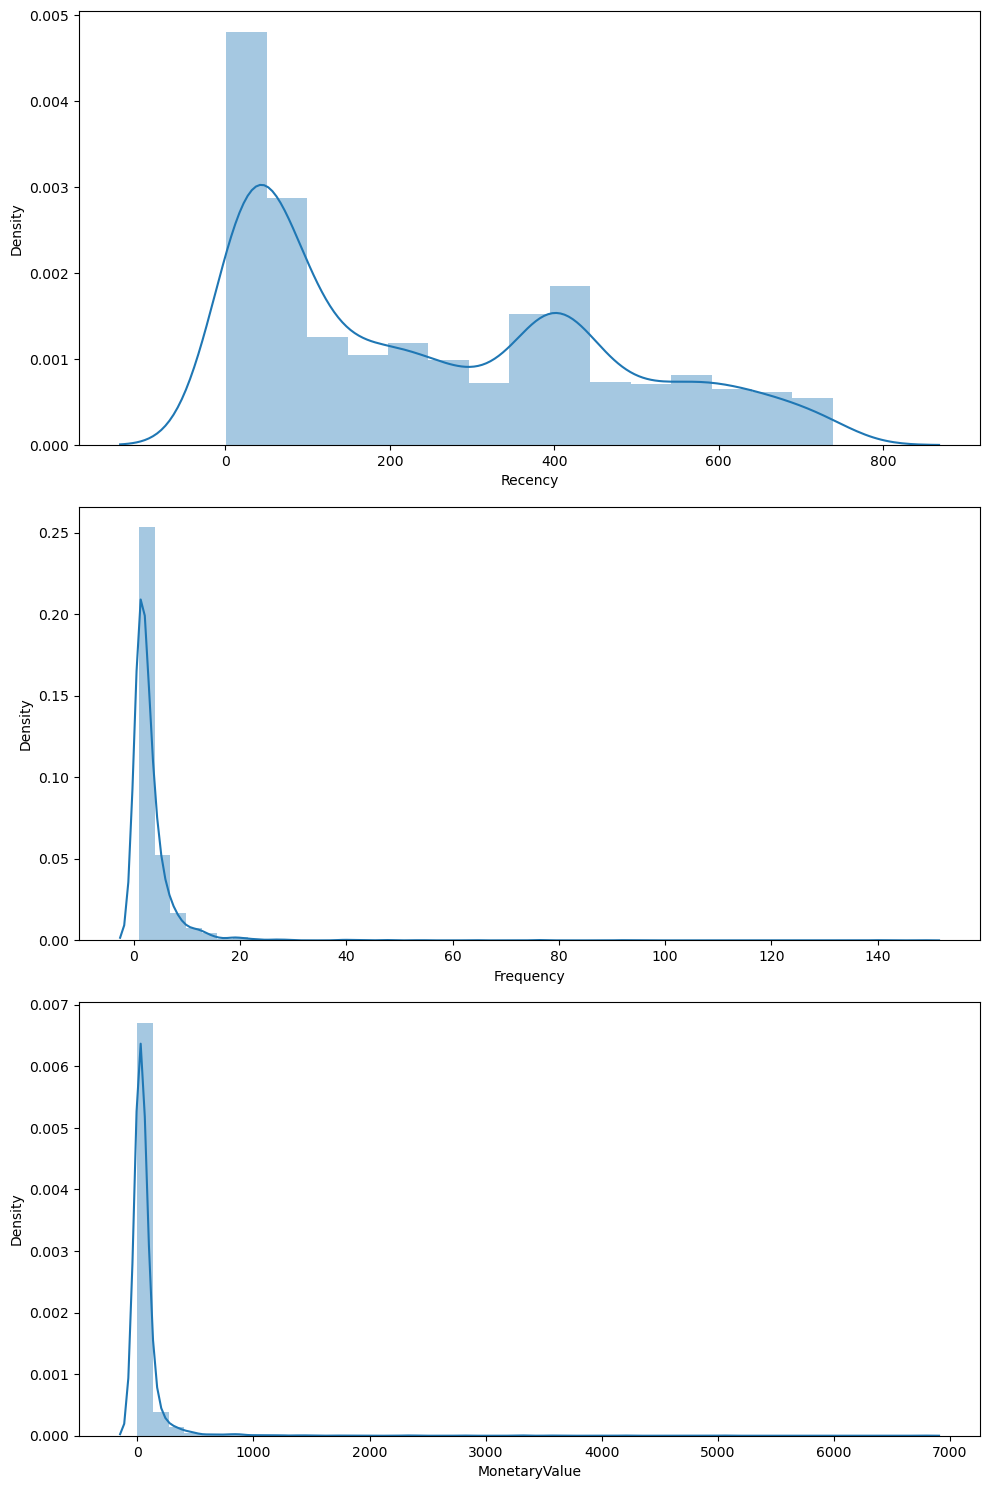

In [90]:
fig, ax = plt.subplots(3, 1, figsize=(10,15))
sns.distplot(customers['Recency'],kde = True, ax=ax[0])
sns.distplot(customers['Frequency'],kde = True, ax=ax[1])
sns.distplot(customers['MonetaryValue'],kde = True, ax=ax[2])
plt.tight_layout()
plt.show()

### BoxCox Transformation & K-Means Clustering

In [91]:
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
3032,19.877935,0.000000,2.168703
3033,19.683718,0.570107,2.831448
3034,22.828760,0.000000,2.545822
3035,1.773868,1.204461,2.778060
3036,8.872165,0.811065,4.772762


In [92]:
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


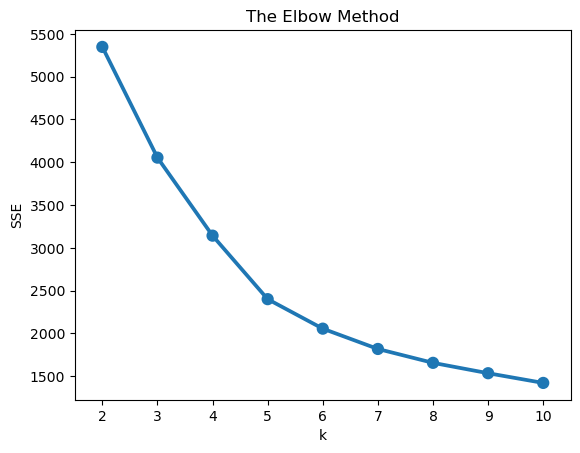

In [93]:
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [94]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(3037,)

In [95]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
Customer ID,,,,
12346.0,722,1,22.5,1
12347.0,247,1,17.0,1
12348.0,359,2,63.6,1
12350.0,311,1,17.4,1
12352.0,37,2,40.4,0


In [96]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          60.4       1.6          20.1   734
1         445.2       1.5          23.3  1356
2         125.8       7.1         180.5   947

In [97]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,1.573036,-1.066355,-0.292707,12346.0,1
1,0.302290,-1.066355,-0.449779,12347.0,1
2,0.693445,0.145756,0.436149,12348.0,1
3,0.537359,-1.066355,-0.437298,12350.0,1
4,-1.066796,0.145756,0.086650,12352.0,0


In [98]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12346.0,1,Recency,1.573036
1,12347.0,1,Recency,0.302290
2,12348.0,1,Recency,0.693445
3,12350.0,1,Recency,0.537359
4,12352.0,0,Recency,-1.066796


#### Snake Plot

D:\Learning\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

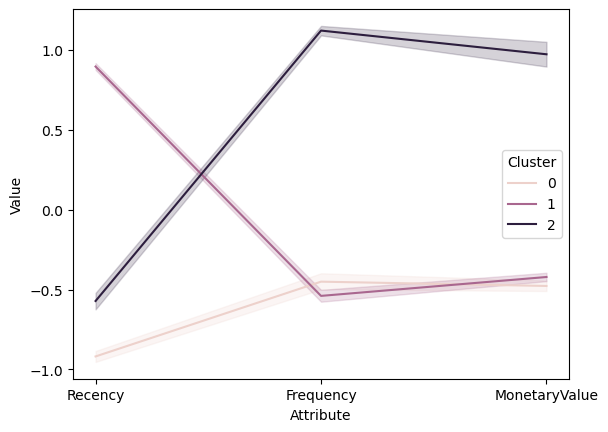

In [99]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

 - Cluster 2 represents frequent, high-spending customers who have made recent purchases, likely indicating loyal patrons.
 - Cluster 0 signifies less frequent, lower-spending customers who have made recent purchases, possibly indicating new customers. 
 - Cluster 1 represents less frequent, lower-spending customers who made purchases in the past, possibly signifying saturated or longtime customers.

In [34]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          79.6       9.4         133.4  1933
1         391.9       3.1          59.6  2240
2          48.6      42.6        1399.9   818

## Conclusion

Customer segmentation, a crucial endeavor, identifies distinct customer traits. K-Means clustering segments loyal, new, and churned customers. Cluster 2 comprises frequent, high-spending recent buyers—loyal customers. Cluster 0 includes less frequent, lower-spending recent buyers—new customers. Cluster 1 consists of infrequent, low-spending old-time buyers—churned customers.

Suggestions:

1. Elevate Cluster 0 by offering enticing deals to transform them into loyal customers and amplify profits.
2. Focus less on Cluster 1 as it primarily constitutes churned-out customers with limited potential for enhancement.
3. Prioritize Cluster 2—our loyal, vital segment—ensuring its growth and retention for shop success.

### Thank You!